In [31]:
from ipywidgets import interact
from brian2 import * #type: ignore
import NeuronEquations
import BrianHF
from ipywidgets import interact
# @interact(tau=(0.1,10.0), tauSpi = (0.1,10.0), beta=(0.1, 5.0, 0.01), Wi=(0.0, 50.0, 0.001), Wk=(-10.0, 0.0, 0.001), vt=(0.1, 1.0, 0.1), vr=(0.0, 1.1, 0.1))

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: 'Exc_pre = Wi'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'ExtIn_post = beta'
 [brian2.codegen.generators.base]


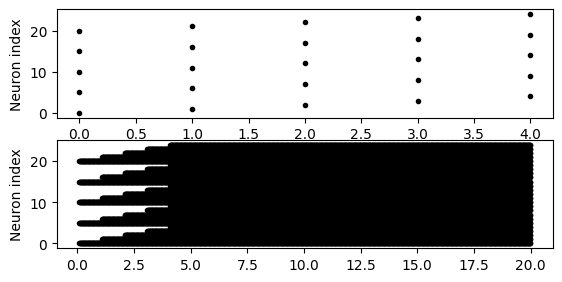

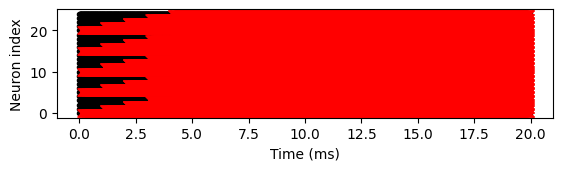

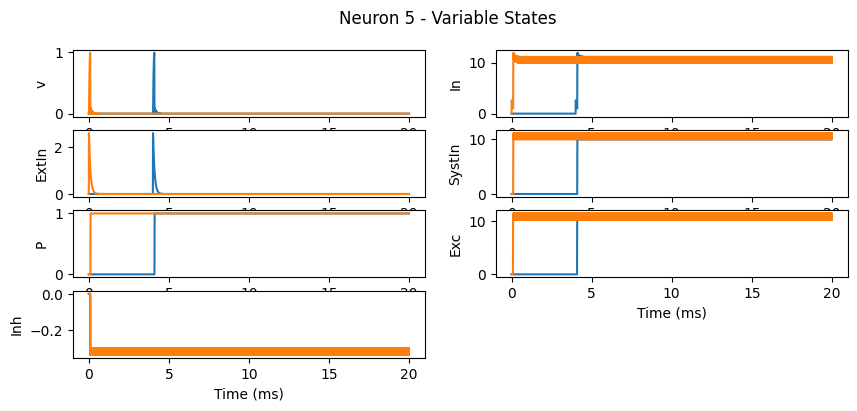

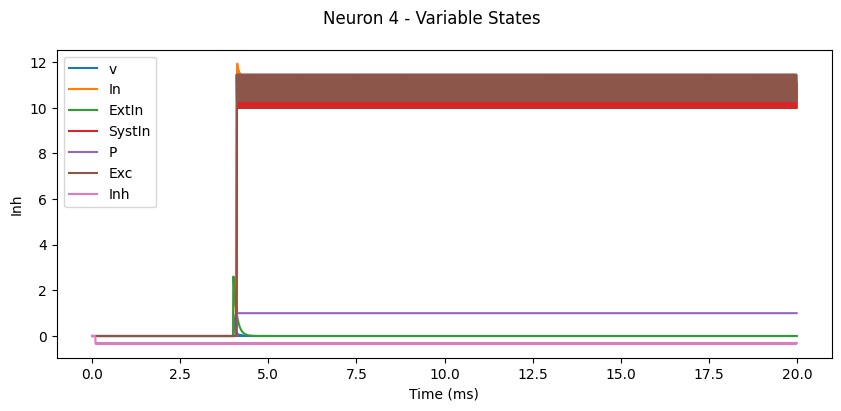

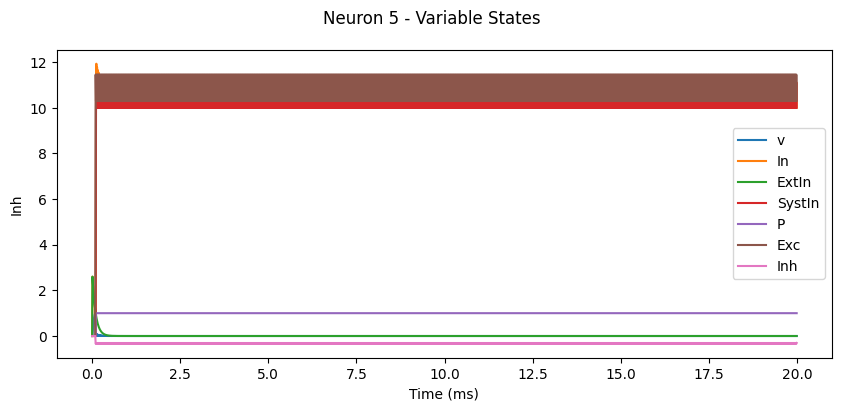

In [38]:
def simulate_neurons(tau=0.1, tauSpi = 0.0, vt=1.0, vr=0.0, beta=2.6, Wi=11.45, Wk=-0.338):
    start_scope()
    
    defaultclock.dt = 0.01*ms

    grid_size_x = 5 # Number of neurons in the x direction
    grid_size_y = 5
    N_Neurons = grid_size_x * grid_size_y # Number of neurons\
        
        
    # Neuron Equation
    Eqs_Neurons = NeuronEquations.EQ_SCM_IF

    # Neuron Parameters
    Neuron_Params = {'tau': tau*ms, 'tauSpi': tauSpi*ms, 'vt': vt, 'vr': vr}
    # Synapse Parameters
    Syn_Params = {'Num_Neighbours' : 8, 'beta': beta, 'Wi': Wi, 'Wk': Wk}


    input = []
    # Input generation
    for i in range (5):
        input.extend(range(i, N_Neurons, 5))
    times = []
    for i in range(5):
        times.extend([i]*5)
    
    G_Spikes = SpikeGeneratorGroup(N_Neurons, input, times*ms)
    
    # indices = np.concatenate((arange(N_Neurons), arange(5), arange(7,11)))
    # times = np.concatenate(([1]*N_Neurons, [2]*5, [3]*4))*ms
    # G_Spikes = SpikeGeneratorGroup(N_Neurons, indices, times)

    G_Neurons = NeuronGroup(N_Neurons, Eqs_Neurons, threshold='v>vt',
                            reset='''
                            v = vr
                            ''',
                            refractory='0*ms',
                            events={'P_ON': 'v > vt', 'P_OFF': '(timestep(t - lastspike, dt) > timestep(dt, dt) and v <= vt)'},
                            method='euler',
                            namespace=Neuron_Params)
    G_Neurons.run_on_event('P_ON', 'P = 1' , when = 'after_thresholds')
    G_Neurons.set_event_schedule('P_OFF', when = 'before_groups')
    G_Neurons.run_on_event('P_OFF', 'P = 0', when = 'before_groups')

    

    # Generate x and y values for each neuron
    x_values = np.repeat(np.arange(grid_size_x), grid_size_y)
    y_values = np.tile(np.arange(grid_size_y), grid_size_x)

    # Assign x, y, and z values to each neuron
    G_Neurons.X = x_values
    G_Neurons.Y = y_values

    # Creating the synapses
    Syn_Input_Neurons = Synapses(G_Spikes, G_Neurons,
                                 'beta : 1 (constant)',
                                 on_pre='''
                                 ExtIn_post = beta
                                 ''',
                                 namespace=Syn_Params)
 
    # Syn_Neurons_Exc = Synapses(G_Neurons, G_Neurons,
    #                            '''
    #                            Wi : 1
    #                            ''',
    #                            on_pre='''
    #                            Exc_post = Wi
    #                            ''')
 
    Syn_Neurons_Inh = Synapses(G_Neurons, G_Neurons,
                               '''
                               Wi : 1
                               Wk : 1 
                               ''',
                               on_pre='''
                               Exc_pre = Wi
                               Inh_post = Wk
                               ''',
                               namespace=Syn_Params)
    
    # SYNAPSE CONNECTIONS:
    # Connect the first synapses from input to G_neurons on a 1 to 1 basis
    Syn_Input_Neurons.connect(condition= 'i == j')
    Syn_Input_Neurons.beta = beta
    
    # # Connect the second set of synapses from a neuron to itself (recurrent)
    # Syn_Neurons_Exc.connect(condition='i == j')
    # Syn_Neurons_Exc.Wi = Wi

    # Connect the last group of synapses from a neuron to its neighbors
    Syn_Neurons_Inh.connect(condition='i != j and abs(X_pre - X_post) <= Num_Neighbours and abs(Y_pre - Y_post) <= Num_Neighbours')
    Syn_Neurons_Inh.Wi = Wi
    Syn_Neurons_Inh.Wk = Wk


    # Monitor the spikes
    SpikeMon_Input = SpikeMonitor(G_Spikes)
    SpikeMon_Neurons = SpikeMonitor(G_Neurons)
    P_ON_Mon = EventMonitor(G_Neurons, 'P_ON')
    P_OFF_Mon = EventMonitor(G_Neurons, 'P_OFF')

    # Monitor the state variables
    StateMon_Neurons = StateMonitor(G_Neurons, ['v', 'In', 'ExtIn', 'SystIn', 'P', 'Exc', 'Inh'], record=True)
    # StateMon_Syn = StateMonitor(Syn_Input_Neurons, ['beta'], record=True)


    # Run the simulation
    # display(scheduling_summary())
    run(20*ms)

    # Plot the results
    figure()
    subplot(311)
    plot(SpikeMon_Input.t/ms, SpikeMon_Input.i, '.k')
    ylabel('Neuron index')

    # Plot the results
    subplot(312)
    plot(SpikeMon_Neurons.t/ms, SpikeMon_Neurons.i, '.k')
    ylabel('Neuron index')
    show()
    
    subplot(313)
    plot(P_OFF_Mon.t/ms, P_OFF_Mon.i, '.k')
    plot(P_ON_Mon.t/ms, P_ON_Mon.i, 'xr')
    xlabel('Time (ms)')
    ylabel('Neuron index')
    show()

    BrianHF.visualise_neurons_states(StateMon_Neurons, [4, 5], 'all', overlap = True)
    BrianHF.visualise_states(StateMon_Neurons, [4, 5], 'all', overlap = True)
    show()

simulate_neurons()